# 0. Preparation

Prior to getting started it is vital to install and import all the required libraries for the project.

In [1]:
#import packages
import numpy as np
import pandas as pd
import yfinance as yf
import pandas_datareader as pdr
import statistics as stats
import datetime as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 1. Input

The first step is to ask the user of the "Stock Investing Advisor" to enter the desired stock ticker.
<br>**For example:** 'AAPL' for Apple Inc. or 'MSFT' for Microsoft Corporation <br>

If the user enters an invalid stock ticker display an error message and ask the user to enter a valid stock ticker.

In [2]:
#identify stock
while True:
    try:
        stock_input = input("Enter Stock Ticker: ")
        stock = yf.Ticker(stock_input)
        ticker = stock.info['symbol']
    except KeyError:
        print("Error - Please enter a valid stock ticker")
        continue
    else:
        break

Enter Stock Ticker: MSFT


Use the Yahoo! Finace market data downloader and the Ticker module in order to access the ticker data of the chosen stock.

In [3]:
stock = yf.Ticker(stock_input)

Now inform the user about the company name according to the chosen stock ticker and indicate if the 'Stock Investing Advisor" is appropriate for the chosen stock.<br>

(The DCF method only is appropiate for business valuations. But not for the valuation of banks and financial istitutions, as financial institutions are highly levered and they do not re-invest debt in the business and instead use it to create products.)

In [4]:
def info_check(stock):
    """
    checks if the chosen stock is valid and appropriate for the firm valuation with the DCF method
    
    Parameters
    ----------
    stock : TYPE: yfinance.ticker.Ticker
            DESCRIPTION: chosen stock, that should be checked
    -------
    """
    try:
        ticker = stock.info['symbol']
        name = stock.info['shortName']
        print('You have chosen "{}" for the valuation!'.format(name))
    except KeyError:
        print("Please input a valid stock ticker")
    try:
        stock.balance_sheet.loc['Inventory'].iloc[1]
        print("Our 'Sale of Shares Advisor' is appropriate for the chosen stock!")
    except KeyError:
        print("Our 'Sale of Shares Advisor' is not appropriate for Banks and Financial Institutions!")
info_check(stock)

You have chosen "Microsoft Corporation" for the valuation!
Our 'Sale of Shares Advisor' is appropriate for the chosen stock!


# 2. Descriptive Statistics & Share Price Development

Provide some descriptive statistics such as the mean, standard deviation, variance, minimum and maximum of the stock price and stock trading volume during the last year.

In [5]:
#set name and ticker of chosen stock
ticker = stock.info['symbol']
name = stock.info['shortName']
#define time range 
end = dt.date.today()
start = end - dt.timedelta(days=365)
#download the stock price data
stock_prices = yf.download(ticker, start, end)
#show the data
stock_prices

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-28,180.740005,184.149994,180.380005,181.399994,179.660416,33810200
2020-05-29,182.729996,184.270004,180.410004,183.250000,181.492691,42130400
2020-06-01,182.539993,183.000000,181.460007,182.830002,181.076721,22622400
2020-06-02,184.250000,185.000000,181.350006,184.910004,183.136765,30794600
2020-06-03,184.820007,185.940002,183.580002,185.360001,183.582458,27311000
...,...,...,...,...,...,...
2021-05-24,247.789993,251.160004,247.509995,250.779999,250.779999,21411500
2021-05-25,251.770004,252.750000,250.820007,251.720001,251.720001,17704300
2021-05-26,251.429993,252.940002,250.750000,251.490005,251.490005,17771600


In [6]:
#summary statistics
def summary_stats(data):
    """
    Summary stats: mean, variance, standard deviation, maximum and minimum.
    Prints descriptive table of the data
    
    Parameters
    ----------
    data :  TYPE: pd.DataFrame
            DESCRIPTION: dataframe for which descriptives will be computed
    -------
    """
    # generate storage for the stats as an empty dictionary
    descriptives = {}
    # loop over columns
    for col in data.columns:
        # fill in the dictionary with descriptive values
        descriptives[col] = [format(data[col].mean(),'f'), # mean
                                   data[col].var(),               # variance
                                   data[col].std(),                # st.dev.
                                   data[col].max(),                # maximum
                                   data[col].min()]      # minimum
    # convert the dictionary to dataframe for a nicer output and name rows
    # Transpose for having the stats as columns
    descriptives = pd.DataFrame(descriptives,
                                   index=['mean', 'var', 'std', 'max', 'min']).transpose()
    # print the descriptives
    print('Descriptive Statistics of {} Share Price and Volume between {} and {}:'.format(name, start, end), '-' * 100, round(descriptives, 2), '-' * 100, '\n\n', sep='\n')
summary_stats(stock_prices)

Descriptive Statistics of Microsoft Corporation Share Price and Volume between 2020-05-29 and 2021-05-29:
----------------------------------------------------------------------------------------------------
                      mean          var          std       max       min
Open            221.422323      351.862       18.758    261.66    180.74
High            223.795276      345.319      18.5828    263.19       183
Low             219.142205      357.106      18.8972    260.17    180.38
Close           221.559606      350.773      18.7289    261.97     181.4
Adj Close       220.348745      367.553      19.1717   261.366    179.66
Volume     30705400.787402  1.00295e+14  1.00147e+07  78983000  10550600
----------------------------------------------------------------------------------------------------





Visualizes the adjusted closing price development over the last year.

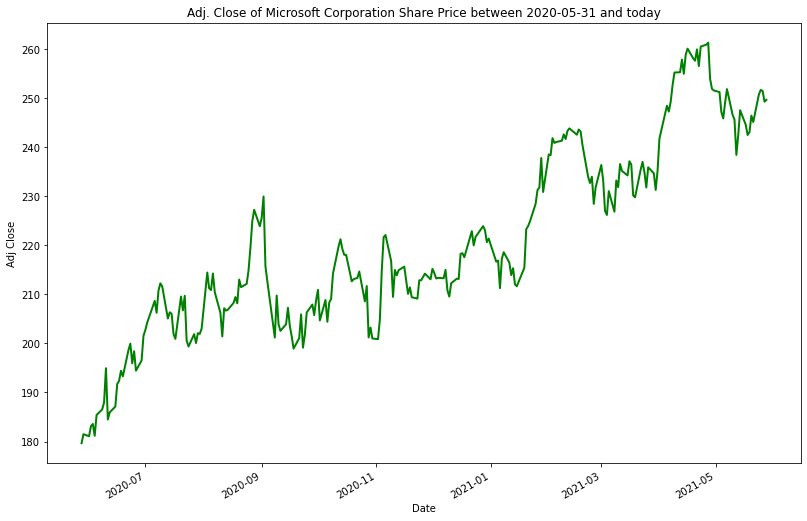

In [7]:
#visualization of stock price development
plt.figure(figsize = (13.5,9))
stock_prices['Adj Close'].plot(linewidth=2.0, color = 'g')
plt.title('Adj. Close of {} Share Price between 2020-05-31 and today'.format(name))
plt.ylabel('Adj Close')
plt.show()

# 3. Assumptions

Make some assumptions that are essential for the excecution of the valuation process.

In [8]:
#assumptions
perpetual_rate = 0.03
riskfree_rate = 0.016

#projection horizon
years = [1, 2, 3, 4, 5]

#present assumptions
print('Assumptions\nPerpetual rate: {} \nRiskree rate: {} \nProjection horizon: {}'.format(perpetual_rate, riskfree_rate, years))

Assumptions
Perpetual rate: 0.03 
Riskree rate: 0.016 
Projection horizon: [1, 2, 3, 4, 5]


# 4. Historical Data & Free Cashflows
Collect the historical data for all parameters and calculate the free cashflows of the past 3 years.<br>

**FCFF Formula:** <br>

$ FCFF = EBIT - Taxes + D&A Expense - CapEx - Δ Net WC $

**FCFF Parameters:**
- FCFF = Free Cash Flow to Firm
- EBIT = Earnings before Interest and Taxes
- Taxes = Cash Taxes
- D&A Expense = Depreciation and Amortization expense
- CapEx = Capital Expenditures
- Δ Net WC = Changes in Net Working Capital

In [9]:
#get historical data
free_cashflows_list = []

for y in range(0,3):
        #EBIT, D&A, CapEx, tax
    ebit = stock.financials.loc['Ebit'].iloc[y]
    tax_expense = stock.financials.loc['Income Tax Expense'].iloc[y]
    depreciation_amortization = stock.cashflow.loc['Depreciation'].iloc[y]
    capex = stock.cashflow.loc['Capital Expenditures'].iloc[y]

        #change in net working capital
    operating_current_assets = stock.balance_sheet.loc['Net Receivables'].iloc[y] + stock.balance_sheet.loc['Inventory'].iloc[y]
    operating_current_liabilities = stock.balance_sheet.loc['Accounts Payable'].iloc[y]
    net_working_capital = operating_current_assets - operating_current_liabilities

    lastyear_operating_current_assets = stock.balance_sheet.loc['Net Receivables'].iloc[y+1] + stock.balance_sheet.loc['Inventory'].iloc[y+1]
    lastyear_operating_current_liabilities = stock.balance_sheet.loc['Accounts Payable'].iloc[y+1]
    lastyear_net_working_capital = lastyear_operating_current_assets - lastyear_operating_current_liabilities

    change_in_net_working_capital = net_working_capital - lastyear_net_working_capital

        #free cash flow
    freecashflow = ebit - tax_expense + depreciation_amortization - capex - change_in_net_working_capital
    free_cashflows_list.append(freecashflow)

#present historical free cashflows of the last three years
print('Historical free cashflows (past 3 years):\n {}'.format(free_cashflows_list))

Historical free cashflows (past 3 years):
 [72774000000.0, 62357000000.0, 33383000000.0]


# 5. Cost of Capital (WACC)
Calculate the Cost of Capital (WACC), the discount rate for the future free cashflows.<br>

**WACC Forumula:**
> $ WACC = (D/D+E) * (1-t)*rd + (E/D+E) * (1-t)*re $

**WACC Parameters:**
- WACC = Cost of Capital
- D = Value of Dept
- E = Value of Equity
- D+E = Value of Firm
- (D/D+E) = Dept Share
- (E/D+E) = Equity Share
- rd = Posttax Cost of Dept
- re = Cost of Equity
- t = Tax Rate

In [10]:
##Calculate Cost of Capital
    
#capital structure
Equity = stock.balance_sheet.loc['Total Stockholder Equity'].iloc[0] / stock.balance_sheet.loc['Total Assets'].iloc[0]
Dept = stock.balance_sheet.loc['Total Liab'].iloc[0] / stock.balance_sheet.loc['Total Assets'].iloc[0]

#present equity share and dept share
print('Equity share:\n {} \nDept share:\n {}'.format(Equity, Dept))

Equity share:
 0.39263086976579015 
Dept share:
 0.6073691302342098


In [11]:
#cost of equity
    #get market index
if stock.info["country"] == "United States":
    benchmark = "^GSPC"
elif stock.info["country"] == "Switzerland":
    benchmark = "^SSMI"
elif stock.info["country"] == "Germany":
    benchmark = "^GDAXI"
elif stock.info["country"] == "United Kingdom":
    benchmark = "^FTSE"
elif stock.info["country"] == "France":
    benchmark = "^FCHI"
elif stock.info["country"] == "Italy":
    benchmark = "FTSEMIB.MI"
elif stock.info["country"] == "Spain":
    benchmark = "^IBEX"
elif stock.info["country"] == "Japan":
    benchmark = "^N225"
else:
    benchmark = "MWL=F" #msci world
    
    #calculate average market return
histcl_market_data = pdr.get_data_yahoo(benchmark)["Adj Close"]
yrly_market_return = histcl_market_data.resample('Y').ffill().pct_change()
yrly_market_return = yrly_market_return.dropna(axis=0) #drop NaN in first row

average_market_return = yrly_market_return.mean()

#calculate equity cost
try:
    beta = stock.info['beta']
    cost_equity = riskfree_rate + beta * (average_market_return - riskfree_rate)
except ValueError:
    histcl_stock_data = pdr.get_data_yahoo(stock_input)["Adj Close"]
    yrly_stock_return = histcl_market_data.resample('Y').ffill().pct_change()
    yrly_stock_return = yrly_stock_return.dropna(axis=0) #drop NaN in first row
    cost_equity = yrly_stock_return.mean()

cost_equity

#present cost of equity
print('Cost of equity:\n {}'.format(cost_equity))

Cost of equity:
 0.11399908034555362


In [12]:
#cost of dept
histcl_interest_expense = [stock.financials.loc['Interest Expense'].iloc[0], 
                           stock.financials.loc['Interest Expense'].iloc[1], 
                           stock.financials.loc['Interest Expense'].iloc[2]]
avg_interest_expense = stats.mean(histcl_interest_expense)

histcl_dept_balance = [stock.balance_sheet.loc["Long Term Debt"].iloc[0],
                       stock.balance_sheet.loc["Long Term Debt"].iloc[1],
                       stock.balance_sheet.loc["Long Term Debt"].iloc[2]]
avg_dept_balance = stats.mean(histcl_dept_balance)

cost_dept = abs(avg_interest_expense / avg_dept_balance)

#present cost of dept
print('Cost of dept:\n {}'.format(cost_dept))

Cost of dept:
 0.04035630435001663


In [13]:
#tax shield
tax_rate = tax_expense / (ebit - stock.financials.loc['Interest Expense'].iloc[0])
tax_shield = 1 - tax_rate
tax_shield
#present tax shield
print('Tax shield:\n {}'.format(tax_shield))

Tax shield:
 0.471353820818614


In [14]:
#combinded
WACC = cost_equity * Equity + cost_dept * Dept * tax_shield

#present WACC
print('WACC:\n {}'.format(WACC))

WACC:
 0.05631299333760292


# 6. Cashflow Growth Rate & Free Cashflow Projection

Calculate the historical cashflow growth rates based on the free cashflows of the past three years and predict free cashflows for the projection horizon (in this case for the next 5 years). Afterwards dicount the future free cashflows with the Cost of Capital (WAAC).

In [15]:
#cashflow growth rate
histcl_cashflow_growthrates = []

cashflow_growthrate_1 = free_cashflows_list[0] / free_cashflows_list[1] - 1
cashflow_growthrate_2 = free_cashflows_list[1] / free_cashflows_list[2] - 1

histcl_cashflow_growthrates.append(cashflow_growthrate_1)
histcl_cashflow_growthrates.append(cashflow_growthrate_2)

if histcl_cashflow_growthrates[0] > histcl_cashflow_growthrates[1] and histcl_cashflow_growthrates[1] > 0:
    cashflow_growthrate = histcl_cashflow_growthrates[1]
elif histcl_cashflow_growthrates[0] <= 0.3:
    cashflow_growthrate = histcl_cashflow_growthrates[0]
else:
    cashflow_growthrate = stats.mean(histcl_cashflow_growthrates)

#present historical cashflow growth rates
print('Historical cashflow growth rates:\n {}'.format(histcl_cashflow_growthrates))

Historical cashflow growth rates:
 [0.16705422005548698, 0.8679267890842643]


In [16]:
#predict future cashflows
future_freecashflow = []

for year in years:
    cashflow = free_cashflows_list[0] * (1 + cashflow_growthrate) ** year
    if cashflow >= 0: #prevent negative cashflows
        future_freecashflow.append(cashflow)
    else:
        future_freecashflow.append(0)
#present futere free cashflows (next 5 years)
print('Future free cashflows (next 5 years):\n {}'.format(future_freecashflow))

Future free cashflows (next 5 years):
 [84931203810.31801, 99119319821.22429, 115677620486.3893, 135002055154.61766, 157554718184.36017]


In [17]:
#discount the future free cashflows
discountfactor = []
discounted_future_freecashflow = []

for year in years:
    discountfactor.append((1 + WACC) ** year)

#discount the future free cashflows 
for x in range(0, len(years)):
    discounted_future_freecashflow.append(future_freecashflow[x] / discountfactor[x])

#present the discounted future free cashflows
print('Discounted future free cashflows:\n {}'.format(discounted_future_freecashflow))

Discounted future free cashflows:
 [80403445139.83798, 88832742330.43307, 98145746071.21144, 108435101958.73686, 119803168323.4677]


# 7. Terminal Value

Calculate the terminal value with the Gordon Growth Rate and discount the terminal value with the WACC.

In [18]:
#determine the gordon growth rate
if WACC - perpetual_rate > 0:
    gordon_growth_rate = WACC - perpetual_rate
else:
    gordon_growth_rate = 0.01

#calculate terminal value and discount the terminal value
terminal_value = future_freecashflow[-1] * (1 + perpetual_rate) / (gordon_growth_rate)

#present terminal value
print('Terminal value:\n {}'.format(terminal_value))

Terminal value:
 6167346969908.617


In [19]:
#discount the terminal value
discounted_terminal_value = terminal_value / discountfactor[-1] ** years[-1]

#append the discounted future free cashflows list with the discounted terminal value
discounted_future_freecashflow.append(discounted_terminal_value)

#present the discounted future free cashflows with present terminal value
discounted_future_freecashflow

print('Discounted future free cashflows with present terminal value:\n {}'.format(discounted_future_freecashflow))

Discounted future free cashflows with present terminal value:
 [80403445139.83798, 88832742330.43307, 98145746071.21144, 108435101958.73686, 119803168323.4677, 1567771747965.18]


# 8. Implied Value per Share
Calcualte the fair value per share.<br>

In [20]:
#get instrinsic value
enterprise_value = sum(discounted_future_freecashflow)
equity_value = enterprise_value + stock.balance_sheet.loc['Cash'].iloc[0] - stock.balance_sheet.loc['Long Term Debt'].iloc[0]

#prevent negative equity value
if equity_value >= 0:
    equity_value = equity_value
else:
    equity_value = 0.01
    
#get the amount of outstanding shares
shares_outstanding = stock.info['sharesOutstanding']

#calculate the value per share
fairvalue_per_share = round(equity_value / shares_outstanding, 2)
fairvalue_per_share

# present the fair value per share
print('Fair value per share:\n {}'.format(fairvalue_per_share))

Fair value per share:
 267.86


# 9. Current Share Price
Collect the current market value of the share as basis for our recommendation.

In [21]:
#current stock price
current_shareprice = stock.info['previousClose']
current_shareprice

# present the current stock price
print('Current Share Price:\n {}'.format(current_shareprice))

Current Share Price:
 249.31


# 10. Recommendation

Display the recommendation of the "Stock Investing Advisor".

In [22]:
#Recommendation
if fairvalue_per_share > current_shareprice * 1.09:
    advice = "BUY"
elif fairvalue_per_share > current_shareprice:
    advice = "HOLD"
elif fairvalue_per_share > current_shareprice * 0.91:
    advice = "HOLD"
elif fairvalue_per_share < current_shareprice:
    advice = "SELL"
else:
    advice = "HOLD"

In [23]:
#Conclusion
if fairvalue_per_share > current_shareprice * 1.17:
    concl = "highly undervalued"
elif fairvalue_per_share > current_shareprice * 1.05:
    concl = "slightly undervalued"
elif fairvalue_per_share > current_shareprice:
    concl = "efficient pricing"
elif fairvalue_per_share > current_shareprice * 0.95:
    concl = "efficient pricing"
elif fairvalue_per_share > current_shareprice * 0.86:
    concl = "slightly overvalued"
elif fairvalue_per_share < current_shareprice:
    concl = "highly overvalued"
else:
    concl = "efficient pricing"

In [24]:
#final output
print("")
print("---------------------------------------------------\n")
print("Conclusion: " + concl)
print("Recommendation: " + advice)
print("")
print("  -> Fair value of " + name + ": " + str(fairvalue_per_share) + " " + str(stock.info["currency"]))
print("")
print("  -> Current Share Price: " + str(current_shareprice) + " " + str(stock.info["currency"]))
print("")
print("---------------------------------------------------")


---------------------------------------------------

Conclusion: slightly undervalued
Recommendation: HOLD

  -> Fair value of Microsoft Corporation: 267.86 USD

  -> Current Share Price: 249.31 USD

---------------------------------------------------
